In [1]:
import numpy as np
import os
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# tensorflow and related layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation

# reports
from sklearn.metrics import confusion_matrix, classification_report

# progress status
from tqdm.notebook import tqdm

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

from scipy.special import log_softmax

In [2]:
print("Tensorflow version:", tf.__version__)
print("Keras version:", keras.__version__)

Tensorflow version: 2.4.1
Keras version: 2.4.0


Define Model parameters

In [3]:
model_params = {
    "n_epochs": 20,
    "batch_size": 32,
    "activation_output": "softmax",
    "loss": "sparse_categorical_crossentropy",
    "optimizer": keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    "metrics": ["accuracy"]
}

# Function to plot the predictions' probability distribution for a single instance

In [4]:
def plot_predictions_distribution_for_single_instance(instance_predictions, class_names):
    plt.figure(figsize=(8,6))
    for class_i in range(0, instance_predictions.shape[-1]):
        plt.plot(instance_predictions[..., class_i], label=class_names[class_i])
    plt.grid()
    plt.legend()

# Load the Dataset

Load the data from Keras

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

Explore the data related to its shape, data type, and min/max value in the matrix

In [6]:
print("X train data shape:", X_train_full.shape)
print("y train data shape:", y_train_full.shape)
print("X test data shape:", X_test.shape)
print("y test data shape:", y_test.shape)

X train data shape: (60000, 28, 28)
y train data shape: (60000,)
X test data shape: (10000, 28, 28)
y test data shape: (10000,)


In [7]:
print("X train data type:", X_train_full.dtype)
print("y train data type:", y_train_full.dtype)
print("X test data type:", X_test.dtype)
print("y test data type:", y_test.dtype)

X train data type: uint8
y train data type: uint8
X test data type: uint8
y test data type: uint8


In [8]:
print("X train type:", type(X_train_full))
print("y train type:", type(y_train_full))
print("X test type:", type(X_test))
print("y test type:", type(y_test))

X train type: <class 'numpy.ndarray'>
y train type: <class 'numpy.ndarray'>
X test type: <class 'numpy.ndarray'>
y test type: <class 'numpy.ndarray'>


In [9]:
print("Maximum matrix value:", X_train_full.max())
print("Minimum matrix value:", X_train_full.min())

Maximum matrix value: 255
Minimum matrix value: 0


# Split the train data into *train* and *validation* sets

In [10]:
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [11]:
print("X validation data shape:", X_valid.shape)
print("y validation data shape:", y_valid.shape)

X validation data shape: (5000, 28, 28)
y validation data shape: (5000,)


# Normalize the data

In [12]:
# normalization
def normalize_pics(data):
    return data / 255.

In [13]:
X_train_normalized = normalize_pics(X_train)
X_valid_normalized = normalize_pics(X_valid)
X_test_normalized = normalize_pics(X_test)

In [14]:
print("Maximum matrix value:", X_train_normalized.max())
print("Minimum matrix value:", X_train_normalized.min())

Maximum matrix value: 1.0
Minimum matrix value: 0.0


In [15]:
print("X train normalized data shape:", X_train_normalized.shape)
print("X validation normalized data shape:", X_valid_normalized.shape)
print("X test normalized data shape:", X_test_normalized.shape)

X train normalized data shape: (55000, 28, 28)
X validation normalized data shape: (5000, 28, 28)
X test normalized data shape: (10000, 28, 28)


# Scale the inputs to mean 0 and standard deviation 1

Compute the mean and std from the X_train full set pixels

In [16]:
pixel_means = X_train_full.mean(axis=0, keepdims=True)
pixel_stds = X_train_full.std(axis=0, keepdims=True)

In [17]:
# standardization
def scale_pics(data, pixel_means, pixel_stds):
    return (data - pixel_means) / pixel_stds

In [18]:
X_train_scaled = scale_pics(X_train, pixel_means, pixel_stds)
X_valid_scaled = scale_pics(X_valid, pixel_means, pixel_stds)
X_test_scaled = scale_pics(X_test, pixel_means, pixel_stds)

# Transform the data to fit the CNN's dimension expectations

In [19]:
X_train_normalized_cnn = X_train_normalized[..., np.newaxis]
X_valid_normalized_cnn = X_valid_normalized[..., np.newaxis]
X_test_normalized_cnn = X_test_normalized[..., np.newaxis]

In [20]:
print("X train normalized data shape:", X_train_normalized_cnn.shape)
print("X validation normalized data shape:", X_valid_normalized_cnn.shape)
print("X test normalized data shape:", X_test_normalized_cnn.shape)
print("X train normalized max value:", X_train_normalized_cnn.max())
print("X train normalized min value:", X_train_normalized_cnn.min())

X train normalized data shape: (55000, 28, 28, 1)
X validation normalized data shape: (5000, 28, 28, 1)
X test normalized data shape: (10000, 28, 28, 1)
X train normalized max value: 1.0
X train normalized min value: 0.0


# Plot the data and define the classes

Plot an instance

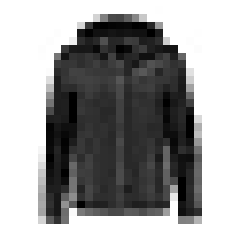

In [21]:
plt.imshow(X_train_normalized[0], cmap="binary")
plt.axis('off')
plt.show()

Unique values of y_train data:

In [22]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

List of class names to know what exactly each number depicts

In [23]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [24]:
class_names[y_train[0]]

'Coat'

Some samples from the MNIST Fashion dataset

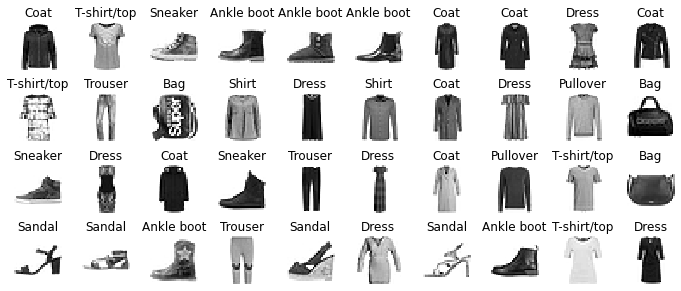

In [25]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train_normalized[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# Make prediction for single instances

## Instance to predict 01 - Ankle boot

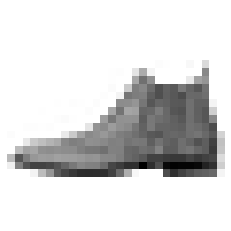

In [26]:
plt.imshow(X_test_normalized[0], cmap="binary")
plt.axis('off')
plt.show()

In [27]:
class_names[y_test[0]]

'Ankle boot'

## Instance  to predict 02 - Coat

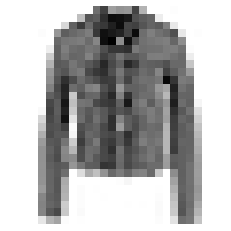

In [28]:
plt.imshow(X_test_normalized[10], cmap="binary")
plt.axis('off')
plt.show()

In [29]:
class_names[y_test[10]]

'Coat'

# Simple model

## Initialize the model and its architecture

In [30]:
model_simple = keras.models.Sequential()
model_simple.add(keras.layers.Flatten(input_shape=[28, 28]))
model_simple.add(keras.layers.Dense(300, activation="relu"))
model_simple.add(keras.layers.Dense(100, activation="relu"))
model_simple.add(keras.layers.Dense(10, activation="softmax"))

Reset all state generated by Keras (if a model was initiated previously)

In [31]:
keras.backend.clear_session()

In [32]:
model_simple = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu", kernel_initializer='he_uniform'),
    keras.layers.Dense(100, activation="relu", kernel_initializer='he_uniform'),
    keras.layers.Dense(10, activation="softmax")
])

Get model's list of layers

In [33]:
model_simple.layers

Display model's summary: layers with their names, their output shape, and the number of parameters

In [34]:
model_simple.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Plot model's summary

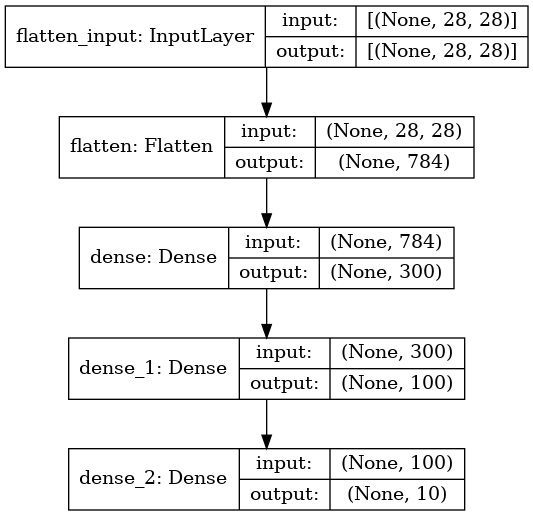

In [35]:
keras.utils.plot_model(model_simple, "fashion_mnist_model.png", show_shapes=True)

## Description of a layer (in this case, Dense) 

In [36]:
# name
hidden1 = model_simple.layers[1]
hidden1.name

'dense'

In [37]:
# check if it is hidden or not
model_simple.get_layer(hidden1.name) is hidden1

True

In [38]:
# get layer's weights and biases
weights, biases = hidden1.get_weights()

In [39]:
# weights' values
weights[5]

array([ 0.08638643,  0.01047292, -0.03106006,  0.03670789, -0.04781865,
        0.01388142,  0.02372251, -0.0502158 ,  0.02104162,  0.04844961,
        0.02953007, -0.05797079,  0.02882975,  0.08435396,  0.06137309,
       -0.0365416 ,  0.02144235,  0.03960829,  0.00081158, -0.08108427,
       -0.0193755 , -0.00564279,  0.06111278,  0.0663498 , -0.07500501,
       -0.07678579,  0.02225731,  0.0064536 ,  0.04960679, -0.05605847,
       -0.07255901, -0.00733271, -0.05567595, -0.02564432,  0.0840748 ,
        0.05180534,  0.0775819 , -0.03256639,  0.08727967, -0.04939087,
       -0.02300654, -0.06733806, -0.04634434, -0.04670567, -0.04453361,
        0.07660349,  0.05580015, -0.06644477,  0.05343934,  0.02162214,
        0.02110711,  0.05253082, -0.01028174,  0.02007417,  0.02403441,
        0.00990935, -0.07899092,  0.01655593, -0.0666851 , -0.06202734,
        0.05867659,  0.0347885 ,  0.01871238,  0.03217603, -0.03072682,
        0.00838172, -0.03927466,  0.0050872 , -0.06909116, -0.03

In [40]:
# weights' shape
weights.shape

(784, 300)

In [41]:
# biases values
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [42]:
# biases' values
biases.shape

(300,)

## Compile the model

In [43]:
model_simple.compile(loss=model_params["loss"], 
                     optimizer=model_params["optimizer"], 
                     metrics=model_params["metrics"])

## Train the model

In [44]:
history_simple = model_simple.fit(X_train_normalized, y_train, epochs=model_params["n_epochs"], 
                                  validation_data=(X_valid_normalized, y_valid))

Epoch 1/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6394 - accuracy: 0.7773 - val_loss: 0.3748 - val_accuracy: 0.8664
Epoch 2/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3804 - accuracy: 0.8628 - val_loss: 0.3694 - val_accuracy: 0.8674
Epoch 3/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3437 - accuracy: 0.8732 - val_loss: 0.3380 - val_accuracy: 0.8764
Epoch 4/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3140 - accuracy: 0.8838 - val_loss: 0.3176 - val_accuracy: 0.8836
Epoch 5/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3026 - accuracy: 0.8865 - val_loss: 0.3105 - val_accuracy: 0.8842
Epoch 6/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2762 - accuracy: 0.8975 - val_loss: 0.3204 - val_accuracy: 0.8836
Epoch 7/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2686 - accuracy: 0.9000 - val_loss: 0.3023 - val_accuracy:

Training parameters

In [45]:
history_simple.params

{'verbose': 1, 'epochs': 20, 'steps': 1719}

Training epochs

In [46]:
print(history_simple.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


Training keys of the metrics

In [47]:
history_simple.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Train evaluation though the epochs

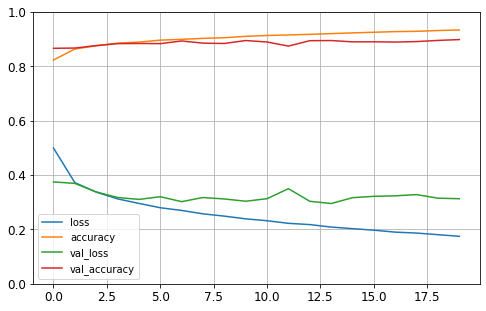

In [48]:
pd.DataFrame(history_simple.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Evaluate the model on the Test data

**Model accuracy**

Evaluate on test data

In [49]:
loss, accuracy = model_simple.evaluate(X_test, y_test)

313/313 [==============================] - 0s 916us/step - loss: 69.7397 - accuracy: 0.8364


In [50]:
print("Accuracy: %.3f" % (accuracy * 100))

Accuracy: 83.640


Make the predictions based on the unseen test data

In [51]:
predictions_simple = np.argmax(model_simple.predict(X_test_normalized, verbose=1), axis=-1)

313/313 [==============================] - 0s 450us/step


Shape of predictions

In [52]:
predictions_simple.shape

(10000,)

Confusion matrix

In [53]:
print(confusion_matrix(y_test, predictions_simple))

[[826   3  29  21   7   1 101   0  12   0]
 [  1 978   1  13   3   0   3   0   1   0]
 [ 13   0 770   8 149   1  58   0   1   0]
 [ 18   3  12 891  54   0  17   0   5   0]
 [  0   1  46  18 889   0  45   0   1   0]
 [  0   0   0   1   0 967   0  19   1  12]
 [ 80   0  71  35  78   0 722   0  14   0]
 [  0   0   0   0   0  13   0 973   1  13]
 [  5   1   4   2   5   2   1   3 977   0]
 [  1   0   0   0   0   8   0  52   0 939]]


Classification report

In [54]:
print(classification_report(y_test, predictions_simple))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1000
           1       0.99      0.98      0.98      1000
           2       0.83      0.77      0.80      1000
           3       0.90      0.89      0.90      1000
           4       0.75      0.89      0.81      1000
           5       0.97      0.97      0.97      1000
           6       0.76      0.72      0.74      1000
           7       0.93      0.97      0.95      1000
           8       0.96      0.98      0.97      1000
           9       0.97      0.94      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



## Predictions

### Instance - Ankle boot

In [55]:
y_proba_softmax = model_simple.predict(X_test_normalized[0:1])
y_proba_softmax.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],
      dtype=float32)

In [56]:
y_pred = np.argmax(model_simple.predict(X_test_normalized[0:1]), axis=-1)
y_pred

array([9])

In [57]:
np.array(class_names)[y_pred]

array(['Ankle boot'], dtype='<U11')

### Instance - Coat

In [58]:
y_proba_softmax = model_simple.predict(X_test_normalized[10:11])
y_proba_softmax.round(2)

array([[0.  , 0.  , 0.05, 0.  , 0.94, 0.  , 0.01, 0.  , 0.  , 0.  ]],
      dtype=float32)

In [59]:
y_pred = np.argmax(model_simple.predict(X_test_normalized[10:11]), axis=-1)
y_pred

array([4])

In [60]:
np.array(class_names)[y_pred]

array(['Coat'], dtype='<U11')

### Make a prediction for a batch of instances

In [61]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [62]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [63]:
test_indices = range(3,7)
list(test_indices)

[3, 4, 5, 6]

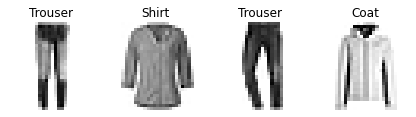

In [64]:
plt.figure(figsize=(7.2, 2.4))
for index, image_number in enumerate(list(test_indices)):
    plt.subplot(1, 4, index + 1)
    plt.imshow(X_test_normalized[image_number], cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[image_number]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [65]:
y_test[3:7]

array([1, 6, 1, 4], dtype=uint8)

Make the predictions

In [66]:
y_proba_softmax = model_simple.predict(X_test_normalized[3:7])
y_proba_softmax.round(2)

array([[0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.95, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [67]:
y_pred = np.argmax(model_simple.predict(X_test_normalized[3:7]), axis=-1)
y_pred

array([1, 6, 1, 4])

In [68]:
np.array(class_names)[y_pred]

array(['Trouser', 'Shirt', 'Trouser', 'Coat'], dtype='<U11')

# Simple Model with Dropouts

Reset all state generated by Keras

In [69]:
keras.backend.clear_session()

## Build and Train the model

Add Dropout layers

In [70]:
model_simple_drp = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

Compile the model

In [71]:
model_simple_drp.compile(loss=model_params["loss"], 
                         optimizer=model_params["optimizer"], 
                         metrics=model_params["metrics"])

Train the model

In [72]:
history_simple_drp = model_simple_drp.fit(X_train_normalized, y_train, epochs=model_params["n_epochs"], 
                                          validation_data=(X_valid_normalized, y_valid))

Epoch 1/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7988 - accuracy: 0.7095 - val_loss: 0.4204 - val_accuracy: 0.8502
Epoch 2/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4951 - accuracy: 0.8170 - val_loss: 0.3831 - val_accuracy: 0.8604
Epoch 3/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4537 - accuracy: 0.8351 - val_loss: 0.3648 - val_accuracy: 0.8692
Epoch 4/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4279 - accuracy: 0.8409 - val_loss: 0.3391 - val_accuracy: 0.8774
Epoch 5/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4129 - accuracy: 0.8464 - val_loss: 0.3294 - val_accuracy: 0.8786
Epoch 6/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3915 - accuracy: 0.8578 - val_loss: 0.3280 - val_accuracy: 0.8794
Epoch 7/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3825 - accuracy: 0.8588 - val_loss: 0.3274 - val_accuracy:

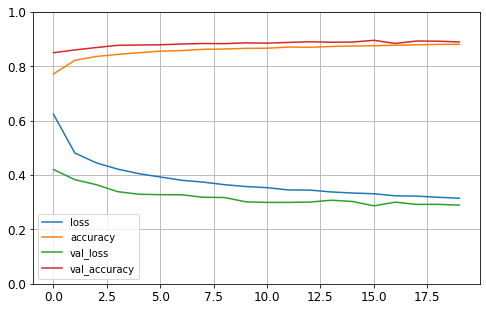

In [73]:
pd.DataFrame(history_simple_drp.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Evaluate the model on the Test data

In [74]:
loss, accuracy = model_simple_drp.evaluate(X_test, y_test)

313/313 [==============================] - 0s 939us/step - loss: 35.2466 - accuracy: 0.8411


In [75]:
print("Accuracy: %.3f" % (accuracy * 100))

Accuracy: 84.110


## Predictions

### Instance - Ankle boot

In [76]:
y_proba_softmax = model_simple_drp.predict(X_test_normalized[0:1])
y_proba_softmax.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.96]],
      dtype=float32)

In [77]:
y_pred = np.argmax(model_simple_drp.predict(X_test_normalized[0:1]), axis=-1)
y_pred

array([9])

In [78]:
np.array(class_names)[y_pred]

array(['Ankle boot'], dtype='<U11')

### Instance - Coat

In [79]:
y_proba_softmax = model_simple_drp.predict(X_test_normalized[10:11])
y_proba_softmax.round(2)

array([[0.  , 0.  , 0.07, 0.  , 0.89, 0.  , 0.04, 0.  , 0.  , 0.  ]],
      dtype=float32)

In [80]:
y_pred = np.argmax(model_simple_drp.predict(X_test_normalized[10:11]), axis=-1)
y_pred

array([4])

In [81]:
np.array(class_names)[y_pred]

array(['Coat'], dtype='<U11')

# Simple model with Dropout -  Enable MC Dropout in predictions

## Do the Monte Carlo Dropout "trick" by setting the `training` to `True`

**Do also:**
- a) make 100 predictions over the test set
- b) stack the predictions


In [82]:
y_probas = np.stack([model_simple_drp(X_test_normalized, training=True) for sample in tqdm(range(100))])

**For each instance of the test set, compute the mean of the 100 exported probabilities, as well as the standard deviation**

In [83]:
y_proba = y_probas.mean(axis=0)

In [84]:
y_std = y_probas.std(axis=0)

## Predictions

### Instance - Ankle boot

Predict the same instance again as previously with `softmax` and the `dropout` **off**. It is the same as the section above and it is presented to see the difference in the predictions.

In [85]:
y_proba_softmax = model_simple_drp.predict(X_test_normalized[0:1])
y_proba_softmax.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.96]],
      dtype=float32)

Print the first 3 probabilities' distribution from the 100 predicted outputs of that instance

In [86]:
np.round(y_probas[:, 0:1], 2)[:3]

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.96]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.97]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.29, 0.  , 0.7 ]]],
      dtype=float32)

In [87]:
print("Shape of the 100 probability predictions for this instance:", np.round(y_probas[:, 10:11], 2).shape)

Shape of the 100 probability predictions for this instance: (100, 1, 10)


**Predict the class for this instance**

This step is critical as it is also useful to know exactly which other classes it thinks are likely.

In [88]:
np.round(y_proba[0:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.1 , 0.  , 0.89]],
      dtype=float32)

Take a look at the standard deviation of the probability estimates for this istance

In [89]:
np.round(y_std[0:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.1 , 0.  , 0.1 ]],
      dtype=float32)

### Instance - Coat

Predict the same instance again as previously with `softmax` and the `dropout` **off**. It is the same as the section above and it is presented to see the difference in the predictions.

In [90]:
y_proba_softmax = model_simple_drp.predict(X_test_normalized[10:11])
y_proba_softmax.round(2)

array([[0.  , 0.  , 0.07, 0.  , 0.89, 0.  , 0.04, 0.  , 0.  , 0.  ]],
      dtype=float32)

Print the first 3 probabilities' distribution from the 100 predicted outputs of that instance

In [91]:
np.round(y_probas[:, 10:11], 2)[:3]

array([[[0.  , 0.  , 0.06, 0.  , 0.92, 0.  , 0.03, 0.  , 0.  , 0.  ]],

       [[0.  , 0.  , 0.14, 0.  , 0.83, 0.  , 0.03, 0.  , 0.  , 0.  ]],

       [[0.  , 0.  , 0.01, 0.  , 0.97, 0.  , 0.01, 0.  , 0.  , 0.  ]]],
      dtype=float32)

In [92]:
print("Shape of the 100 probability predictions for this instance:", np.round(y_probas[:, 10:11], 2).shape)

Shape of the 100 probability predictions for this instance: (100, 1, 10)


**Predict the class for this instance**

This step is critical as it is also useful to know exactly which other classes it thinks are likely.

In [93]:
np.round(y_proba[10:11], 2)

array([[0.  , 0.  , 0.11, 0.  , 0.85, 0.  , 0.05, 0.  , 0.  , 0.  ]],
      dtype=float32)

Take a look at the standard deviation of the probability estimates for this istance

In [94]:
np.round(y_std[10:11], 2)

array([[0.  , 0.  , 0.09, 0.  , 0.12, 0.  , 0.05, 0.  , 0.  , 0.  ]],
      dtype=float32)

## Evaluate the model on the Test data (with the probabilities this time)

Hold the predicted classes by return the maximum value from each probability estimate

In [95]:
y_pred = np.argmax(y_proba, axis=1)

In [96]:
accuracy = np.sum(y_pred == y_test) / len(y_test)

In [97]:
print("Accuracy: %.3f" % (accuracy * 100))

Accuracy: 88.070


**The model's accuracy got a little boost with this method**

# MC Simple Model Dropout - Transfer the weights

**a) Force the Dropout's `training` argument to `True` by overriding the `call()` method**

**b) Replace the Dropout with the `MCDropout` method**

**c) Get the weights from the previous model and set them to a new one**

## Override the Dropout class to MCDropout

In [98]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

## Build the model

**Because the model is already trained, the Dropout layers are replaced with the MCDropout, and the trained model's weights are set to the new model in order to run again the predictions**

In [99]:
mc_model_simple_drp = keras.models.Sequential([
    MCDropout(layer.rate) if isinstance(layer, keras.layers.Dropout) else layer
    for layer in model_simple_drp.layers
])

In [100]:
mc_model_simple_drp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
mc_dropout (MCDropout)       (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
mc_dropout_1 (MCDropout)     (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
mc_dropout_2 (MCDropout)     (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

In [101]:
mc_model_simple_drp.compile(loss=model_params["loss"], 
                            optimizer=model_params["optimizer"], 
                            metrics=model_params["metrics"])

## Transfer the weights from the previous model

Set the Monte Carlo updated model's weights with these from pre-trained one

In [102]:
mc_model_simple_drp.set_weights(model_simple_drp.get_weights())

## Predictions

In [103]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Use the model straightforward with MC Dropout layer to predict the unique instance's class

### Instance - Ankle Boot

In [104]:
np.round(np.mean([mc_model_simple_drp.predict(X_test_normalized[0:1]) 
                  for sample in tqdm(range(100))], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.1 , 0.  , 0.89]],
      dtype=float32)

### Instance - Coat

In [105]:
np.round(np.mean([mc_model_simple_drp.predict(X_test_normalized[10:11]) 
                  for sample in tqdm(range(100))], axis=0), 2)

array([[0.  , 0.  , 0.09, 0.  , 0.85, 0.  , 0.05, 0.  , 0.  , 0.  ]],
      dtype=float32)

## Evaluate the model on the Test data (with the probabilities this time)

In [106]:
y_probas = np.stack([mc_model_simple_drp(X_test_normalized, training=True) for sample in tqdm(range(100))])

In [107]:
y_proba = y_probas.mean(axis=0)

In [108]:
y_std = y_probas.std(axis=0)

Hold the predicted classes by return the maximum value from each probability estimate

In [109]:
y_pred = np.argmax(y_proba, axis=1)

In [110]:
accuracy = np.sum(y_pred == y_test) / len(y_test)

In [111]:
print("Accuracy: %.3f" % (accuracy * 100))

Accuracy: 87.940


**The model's accuracy got a little boost with this method**

# CNN Simple with Dropout

Reset all state generated by Keras

In [112]:
keras.backend.clear_session()

## Build and train a CNN model

In [113]:
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation("relu"))
model_cnn.add(Dropout(0.5))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation("relu"))
model_cnn.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform'))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation("relu"))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(100, kernel_initializer='he_uniform'))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation("relu"))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(10, activation='softmax'))

In [114]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        2

In [115]:
model_cnn.compile(loss=model_params["loss"], 
                  optimizer=model_params["optimizer"], 
                  metrics=model_params["metrics"])

In [116]:
history_cnn = model_cnn.fit(X_train_normalized_cnn, y_train, epochs=model_params["n_epochs"], 
                        validation_data=(X_valid_normalized_cnn, y_valid))

Epoch 1/20
1719/1719 [==============================] - 18s 10ms/step - loss: 0.7460 - accuracy: 0.7345 - val_loss: 0.6464 - val_accuracy: 0.7888
Epoch 2/20
1719/1719 [==============================] - 18s 10ms/step - loss: 0.4249 - accuracy: 0.8470 - val_loss: 0.4823 - val_accuracy: 0.8490
Epoch 3/20
1719/1719 [==============================] - 18s 10ms/step - loss: 0.3728 - accuracy: 0.8646 - val_loss: 0.4332 - val_accuracy: 0.8524
Epoch 4/20
1719/1719 [==============================] - 18s 10ms/step - loss: 0.3394 - accuracy: 0.8780 - val_loss: 0.4032 - val_accuracy: 0.8642
Epoch 5/20
1719/1719 [==============================] - 18s 10ms/step - loss: 0.3169 - accuracy: 0.8852 - val_loss: 0.3869 - val_accuracy: 0.8664
Epoch 6/20
1719/1719 [==============================] - 18s 10ms/step - loss: 0.2968 - accuracy: 0.8925 - val_loss: 0.4195 - val_accuracy: 0.8528
Epoch 7/20
1719/1719 [==============================] - 18s 10ms/step - loss: 0.2843 - accuracy: 0.8975 - val_loss: 0.4739 -

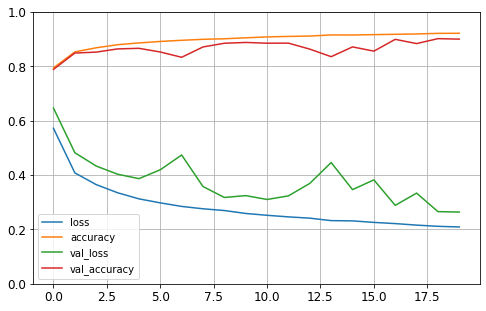

In [117]:
pd.DataFrame(history_cnn.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Evaluate the model on the Test data

In [118]:
# evaluate the model on test dataset
loss, accuracy = model_cnn.evaluate(X_test_normalized_cnn, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.2864 - accuracy: 0.8938


In [119]:
print("Accuracy: %.3f" % (accuracy * 100))

Accuracy: 89.380


## Predictions

In [120]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

**Model instance prediction with `softmax`**

### Instance - Ankle boot

In [121]:
y_proba_softmax = model_cnn.predict(X_test_normalized_cnn[0:1])
y_proba_softmax.round(2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

### Instance - Coat

In [122]:
y_proba_softmax = model_cnn.predict(X_test_normalized_cnn[10:11])
y_proba_softmax.round(2)

array([[0.  , 0.  , 0.01, 0.  , 0.69, 0.  , 0.3 , 0.  , 0.  , 0.  ]],
      dtype=float32)

# MC CNN Dropout model - transfer the weights from the previous CNN

In [123]:
mc_model_cnn_trf = keras.models.Sequential([
    MCDropout(layer.rate) if isinstance(layer, keras.layers.Dropout) else layer
    for layer in model_cnn.layers
])

In [124]:
mc_model_cnn_trf.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
mc_dropout (MCDropout)       (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)       

In [125]:
mc_model_cnn_trf.compile(loss=model_params["loss"], 
                         optimizer=model_params["optimizer"], 
                         metrics=model_params["metrics"])

## Transfer the weights from the previous CNN

In [126]:
mc_model_cnn_trf.set_weights(model_cnn.get_weights())

## Predictions

In [127]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Use the model straightforward with MC Dropout layer to predict the unique instance's class

### Instance - Ankle boot

In [128]:
np.round(np.mean([mc_model_cnn_trf.predict(X_test_normalized_cnn[0:1]) 
                  for sample in tqdm(range(100))], axis=0), 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

### Instance - Coat

In [129]:
np.round(np.mean([mc_model_cnn_trf.predict(X_test_normalized_cnn[10:11]) 
                  for sample in tqdm(range(100))], axis=0), 2)

array([[0.  , 0.  , 0.01, 0.  , 0.95, 0.  , 0.05, 0.  , 0.  , 0.  ]],
      dtype=float32)

## Evaluate the model on the Test data (with the probabilities this time)

Stack the probabilities for all the instances

In [130]:
y_probas = np.stack([mc_model_cnn_trf(X_test_normalized_cnn) for sample in tqdm(range(100))])

Compute the mean and std for the instances' probability estimates

In [131]:
y_proba = y_probas.mean(axis=0)

In [132]:
y_std = y_probas.std(axis=0)

Hold the predicted classes by return the maximum value from each probability estimate

In [133]:
y_pred = np.argmax(y_proba, axis=1)

In [134]:
accuracy = np.sum(y_pred == y_test) / len(y_test)

In [135]:
print("Accuracy: %.3f" % (accuracy * 100))

Accuracy: 91.600


**Model's accuracy is improved**

# MC CNN Dropout model from scratch

Reset all state generated by Keras

In [136]:
keras.backend.clear_session()

## Build and train the model

In [137]:
mc_model_cnn_drp = Sequential()
mc_model_cnn_drp.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
mc_model_cnn_drp.add(BatchNormalization())
mc_model_cnn_drp.add(Activation("relu"))
mc_model_cnn_drp.add(MCDropout(0.5))
mc_model_cnn_drp.add(MaxPooling2D((2, 2)))
mc_model_cnn_drp.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
mc_model_cnn_drp.add(BatchNormalization())
mc_model_cnn_drp.add(Activation("relu"))
mc_model_cnn_drp.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform'))
mc_model_cnn_drp.add(BatchNormalization())
mc_model_cnn_drp.add(Activation("relu"))
mc_model_cnn_drp.add(MaxPooling2D((2, 2)))
mc_model_cnn_drp.add(Flatten())
mc_model_cnn_drp.add(Dense(100, kernel_initializer='he_uniform'))
mc_model_cnn_drp.add(BatchNormalization())
mc_model_cnn_drp.add(Activation("relu"))
mc_model_cnn_drp.add(MCDropout(0.5))
mc_model_cnn_drp.add(Dense(10, activation='softmax'))

In [138]:
mc_model_cnn_drp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
mc_dropout (MCDropout)       (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        2

In [139]:
mc_model_cnn_drp.compile(loss=model_params["loss"], 
                         optimizer=model_params["optimizer"], 
                         metrics=model_params["metrics"])

In [140]:
mc_history_cnn_drp = mc_model_cnn_drp.fit(X_train_normalized_cnn, y_train, epochs=model_params["n_epochs"], 
                                          validation_data=(X_valid_normalized_cnn, y_valid))

Epoch 1/20
1719/1719 [==============================] - 18s 11ms/step - loss: 0.7260 - accuracy: 0.7428 - val_loss: 0.4122 - val_accuracy: 0.8558
Epoch 2/20
1719/1719 [==============================] - 18s 10ms/step - loss: 0.4143 - accuracy: 0.8509 - val_loss: 0.3538 - val_accuracy: 0.8736
Epoch 3/20
1719/1719 [==============================] - 18s 10ms/step - loss: 0.3653 - accuracy: 0.8662 - val_loss: 0.3336 - val_accuracy: 0.8818
Epoch 4/20
1719/1719 [==============================] - 18s 10ms/step - loss: 0.3356 - accuracy: 0.8781 - val_loss: 0.3794 - val_accuracy: 0.8650
Epoch 5/20
1719/1719 [==============================] - 18s 10ms/step - loss: 0.3137 - accuracy: 0.8879 - val_loss: 0.2994 - val_accuracy: 0.8924
Epoch 6/20
1719/1719 [==============================] - 18s 10ms/step - loss: 0.2945 - accuracy: 0.8940 - val_loss: 0.2939 - val_accuracy: 0.8906
Epoch 7/20
1719/1719 [==============================] - 18s 10ms/step - loss: 0.2816 - accuracy: 0.8985 - val_loss: 0.3171 -

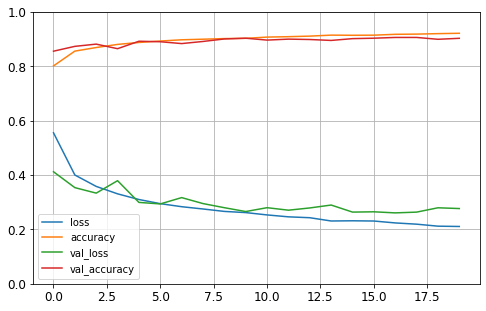

In [141]:
pd.DataFrame(mc_history_cnn_drp.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

**Model accuracy**

In [142]:
# evaluate the model on test dataset
loss, accuracy = mc_model_cnn_drp.evaluate(X_test_normalized_cnn, y_test, verbose=1)

313/313 [==============================] - 1s 3ms/step - loss: 0.3012 - accuracy: 0.8904


In [143]:
print("Accuracy: %.3f" % (accuracy * 100))

Accuracy: 89.040


## Predictions

In [144]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

### Instance - Ankle boot

Use `numpy.squeeze()` to remove all dimensions of size 1 from the NumPy array `ndarray`. `squeeze()` is also provided as a method of `ndarray`.

In [145]:
X_test_normalized_instance = np.squeeze(X_test_normalized_cnn[0])
print(X_test_normalized_instance.shape)

(28, 28)


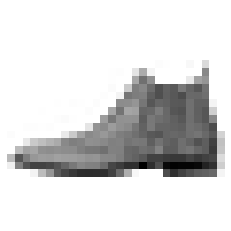

In [146]:
plt.imshow(X_test_normalized_instance, cmap="binary")
plt.axis('off')
plt.show()

In [147]:
class_names[y_test[0]]

'Ankle boot'

Use the model straightforward with MC Dropout layer to predict a unique instance's class

In [148]:
y_pred = np.round(np.mean([mc_model_cnn_drp.predict(X_test_normalized_cnn[0:1]) 
                                  for sample in tqdm(range(100))], axis=0), 2)
print(y_pred)


[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.99]]


In [149]:
y_pred = np.argmax(y_pred, axis=-1)

In [150]:
np.array(class_names)[y_pred]

array(['Ankle boot'], dtype='<U11')

Stack the probabilities for the instance

In [151]:
y_pred_instance = np.stack([mc_model_cnn_drp(X_test_normalized_cnn[0:1]) for sample in tqdm(range(100))], axis=0)

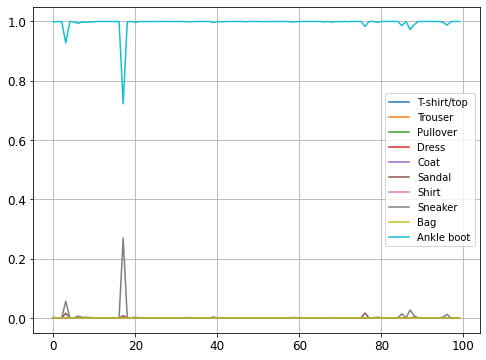

In [152]:
plot_predictions_distribution_for_single_instance(y_pred_instance, class_names)

In [153]:
y_pred_instance = np.squeeze(y_pred_instance)

In [154]:
y_pred_instance.shape

(100, 10)

In [155]:
probas_df = pd.DataFrame(data=y_pred_instance, columns=class_names)

In [156]:
probas_df.head()

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
0,1.089055e-07,1.476250e-06,1.096157e-06,8.147809e-09,7.585831e-06,2.633669e-04,4.131600e-08,0.001737,1.452764e-09,0.997990
1,3.563274e-10,4.146563e-10,1.304689e-10,2.643534e-14,4.303547e-12,5.385515e-07,4.187359e-10,0.000009,3.245421e-09,0.999990
2,2.229473e-08,8.056539e-13,2.232098e-12,2.951565e-13,5.238829e-14,9.098523e-09,4.126006e-13,0.000629,8.504445e-11,0.999371
3,4.512123e-07,3.834104e-08,9.965327e-07,7.314380e-08,6.510824e-07,1.608714e-02,1.038278e-06,0.056261,3.050139e-09,0.927648
4,2.468499e-08,3.257075e-07,2.852375e-10,6.876403e-10,1.901094e-08,1.472925e-05,7.508413e-07,0.000051,9.630654e-09,0.999933


(array([51.,  8.,  8.,  5.,  5.,  3.,  6.,  5.,  5.,  4.]),
 array([1.9780821e-04, 9.2006192e-02, 1.8381457e-01, 2.7562296e-01,
        3.6743134e-01, 4.5923972e-01, 5.5104810e-01, 6.4285648e-01,
        7.3466486e-01, 8.2647324e-01, 9.1828161e-01], dtype=float32),
 <BarContainer object of 10 artists>)

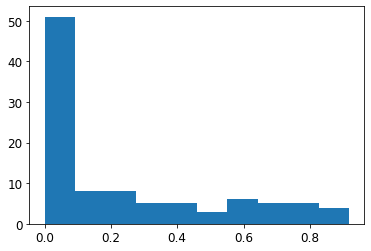

In [220]:
plt.hist(probas_df[class_names[0]])

In [158]:
probas_df_log = probas_df.apply(log_softmax)

In [159]:
probas_df_log.head()

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
0,-4.605174,-4.605186,-4.605170,-4.605171,-4.605164,-4.605407,-4.605175,-4.608130,-4.60517,-4.602746
1,-4.605174,-4.605187,-4.605171,-4.605171,-4.605172,-4.605670,-4.605175,-4.609858,-4.60517,-4.600745
2,-4.605174,-4.605187,-4.605171,-4.605171,-4.605172,-4.605670,-4.605175,-4.609238,-4.60517,-4.601365
3,-4.605173,-4.605187,-4.605170,-4.605170,-4.605171,-4.589583,-4.605174,-4.553606,-4.60517,-4.673087
4,-4.605174,-4.605186,-4.605171,-4.605171,-4.605172,-4.605656,-4.605175,-4.609817,-4.60517,-4.600802


(array([96.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([-4.6051736, -4.6051555, -4.605138 , -4.6051197, -4.6051016,
        -4.6050835, -4.605066 , -4.6050477, -4.6050296, -4.605012 ,
        -4.604994 ], dtype=float32),
 <BarContainer object of 10 artists>)

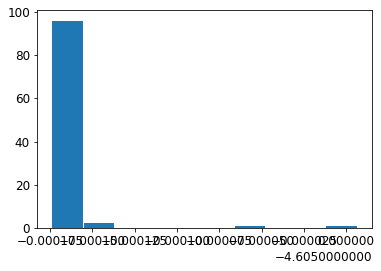

In [160]:
plt.hist(probas_df_log[class_names[0]])

In [161]:
probas_df_exp = probas_df_log.apply(np.exp)

In [162]:
probas_df_exp.head()

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
0,0.01,0.01,0.01,0.01,0.01,0.009998,0.01,0.009970,0.01,0.010024
1,0.01,0.01,0.01,0.01,0.01,0.009995,0.01,0.009953,0.01,0.010044
2,0.01,0.01,0.01,0.01,0.01,0.009995,0.01,0.009959,0.01,0.010038
3,0.01,0.01,0.01,0.01,0.01,0.010157,0.01,0.010529,0.01,0.009343
4,0.01,0.01,0.01,0.01,0.01,0.009995,0.01,0.009954,0.01,0.010044


(array([96.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([0.00999997, 0.01000015, 0.01000033, 0.01000051, 0.01000069,
        0.01000086, 0.01000104, 0.01000122, 0.0100014 , 0.01000158,
        0.01000176], dtype=float32),
 <BarContainer object of 10 artists>)

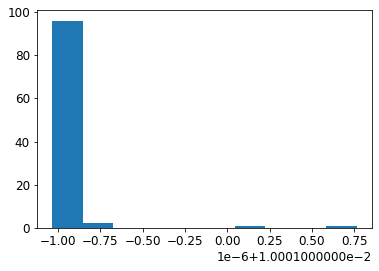

In [163]:
plt.hist(probas_df_exp[class_names[0]])

In [164]:
np.percentile(probas_df_exp["T-shirt/top"], 50)

0.009999966248869896

In [165]:
probas_df["T-shirt/top"].iloc[50]

1.0703637e-09

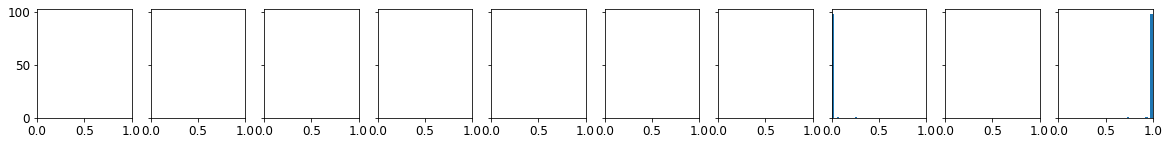

In [166]:
fig, axs = plt.subplots(1, len(class_names), sharey=True, figsize=(20,2))
for i in class_names:
    plt.subplot(1, len(class_names), class_names.index(i) + 1)  # 1 row, 2 cols, subplot X
    axs[class_names.index(i)].set_xlim([0, 1])
    plt.hist(probas_df[class_names[class_names.index(i)]])

### Instance - Coat

Use `numpy.squeeze()` to remove all dimensions of size 1 from the NumPy array `ndarray`. `squeeze()` is also provided as a method of `ndarray`.

In [167]:
X_test_normalized_instance = np.squeeze(X_test_normalized_cnn[10])
print(X_test_normalized_instance.shape)

(28, 28)


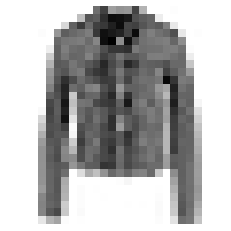

In [168]:
plt.imshow(X_test_normalized_instance, cmap="binary")
plt.axis('off')
plt.show()

In [169]:
class_names[y_test[10]]

'Coat'

Use the model straightforward with MC Dropout layer to predict a unique instance's class

In [170]:
y_pred = np.round(np.mean([mc_model_cnn_drp.predict(X_test_normalized_cnn[10:11]) 
                                  for sample in tqdm(range(100))], axis=0), 2)
print(y_pred)


[[0.   0.   0.03 0.   0.92 0.   0.05 0.   0.   0.  ]]


In [171]:
y_pred = np.argmax(y_pred, axis=-1)

In [172]:
np.array(class_names)[y_pred]

array(['Coat'], dtype='<U11')

In [173]:
y_pred_instance = np.stack([mc_model_cnn_drp(X_test_normalized_cnn[10:11]) for sample in tqdm(range(100))], axis=0)

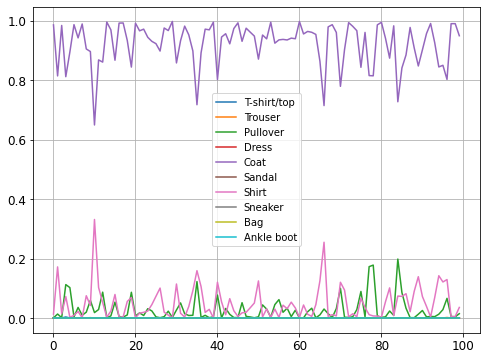

In [174]:
plot_predictions_distribution_for_single_instance(y_pred_instance, class_names)

## Evaluate the model on the Test data (with the probabilities this time)

Stack the probabilities for all the instances

In [175]:
y_probas = np.stack([mc_model_cnn_drp(X_test_normalized_cnn) for sample in tqdm(range(100))])

Compute the mean and std for the instances' probability estimates

In [176]:
y_proba = y_probas.mean(axis=0)

In [177]:
y_std = y_probas.std(axis=0)

Hold the predicted classes by return the maximum value from each probability estimate

In [178]:
y_pred = np.argmax(y_proba, axis=1)

**Model's accuracy is now improved**

In [179]:
accuracy = np.sum(y_pred == y_test) / len(y_test)

In [180]:
print("Accuracy: %.3f" % (accuracy * 100))

Accuracy: 90.280


# Predictions on MNIST with digits

## Load the data

In [181]:
digits_mnist = keras.datasets.mnist

In [182]:
(X_train_digits, y_train_digits), (X_test_digits, y_test_digits) = digits_mnist.load_data()

In [183]:
print("Digits - X train shape:", X_train_digits.shape)
print("Digits - X test shape:", X_test_digits.shape)
print("Digits - y train shape:", X_test_digits.shape)
print("Digits - y test shape:", y_test_digits.shape)

Digits - X train shape: (60000, 28, 28)
Digits - X test shape: (10000, 28, 28)
Digits - y train shape: (10000, 28, 28)
Digits - y test shape: (10000,)


## Transform the data (Scale + 4 dimensions)

In [184]:
X_train_digits_nrm = normalize_pics(X_train_digits)
X_test_digits_nrm = normalize_pics(X_test_digits)

In [185]:
print("Digits - X train normalized shape:", X_train_digits_nrm.shape)
print("Digits - X test normalized shape:", X_test_digits_nrm.shape)
print("Digits - X test max normalized value:", X_test_digits_nrm.max())
print("Digits - X test min normalized value:", X_test_digits_nrm.min())

Digits - X train normalized shape: (60000, 28, 28)
Digits - X test normalized shape: (10000, 28, 28)
Digits - X test max normalized value: 1.0
Digits - X test min normalized value: 0.0


In [186]:
X_train_digits_nrm_cnn = X_train_digits_nrm[..., np.newaxis]
X_test_digits_nrm_cnn = X_test_digits_nrm[..., np.newaxis]

## Predictions

### Instance - 7

In [187]:
X_test_digits_nrm_instance = np.squeeze(X_test_digits_nrm_cnn[0])
print("Shape of digit instance", X_test_normalized_instance.shape)
print("label:", y_test_digits[0])

Shape of digit instance (28, 28)
label: 7


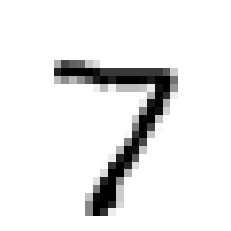

In [188]:
plt.imshow(X_test_digits_nrm_instance, cmap="binary")
plt.axis('off')
plt.show()

#### Simple Model Dropout -  `mc_model_simple_drp`

In [189]:
y_pred_mc_cnn_digit = np.round(np.mean([mc_model_simple_drp.predict(X_test_digits_nrm_cnn[0:1]) 
                                        for sample in tqdm(range(100))], axis=0), 2)
print(y_pred_mc_cnn_digit)


[[0.16 0.   0.02 0.   0.   0.71 0.03 0.   0.05 0.01]]


#### MC Dropout CNN

In [190]:
y_pred_mc_cnn_digit = np.round(np.mean([mc_model_cnn_drp.predict(X_test_digits_nrm_cnn[0:1]) 
                                        for sample in tqdm(range(100))], axis=0), 2)
print(y_pred_mc_cnn_digit)


[[0.59 0.   0.01 0.03 0.01 0.35 0.   0.   0.01 0.  ]]


#### Simple CNN

In [191]:
y_proba_softmax = model_cnn.predict(X_test_digits_nrm_cnn[0:1])
y_proba_softmax.round(2)

array([[0.81, 0.  , 0.  , 0.04, 0.  , 0.  , 0.11, 0.  , 0.04, 0.  ]],
      dtype=float32)

### Instance - 2

In [192]:
X_test_digits_nrm_instance = np.squeeze(X_test_digits_nrm_cnn[1])
print("Shape of digit instance", X_test_normalized_instance.shape)
print("label:", y_test_digits[1])

Shape of digit instance (28, 28)
label: 2


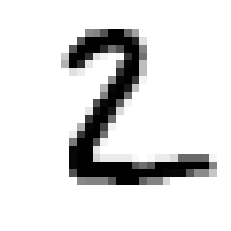

In [193]:
plt.imshow(X_test_digits_nrm_instance, cmap="binary")
plt.axis('off')
plt.show()

#### Simple Model Dropout -  `mc_model_simple_drp`

In [194]:
y_pred_mc_cnn_digit = np.round(np.mean([mc_model_simple_drp.predict(X_test_digits_nrm_cnn[1:2]) 
                                        for sample in tqdm(range(100))], axis=0), 2)
print(y_pred_mc_cnn_digit)


[[0.05 0.04 0.1  0.39 0.24 0.01 0.12 0.01 0.04 0.01]]


#### MC Dropout CNN

In [195]:
y_pred_mc_cnn_digit = np.round(np.mean([mc_model_cnn_drp.predict(X_test_digits_nrm_cnn[1:2]) 
                                        for sample in tqdm(range(100))], axis=0), 2)
print(y_pred_mc_cnn_digit)


[[0.29 0.   0.02 0.03 0.   0.03 0.02 0.   0.6  0.  ]]


#### Simple CNN

In [196]:
y_proba_softmax = model_cnn.predict(X_test_digits_nrm_cnn[1:2])
y_proba_softmax.round(2)

array([[0.48, 0.01, 0.17, 0.02, 0.  , 0.01, 0.19, 0.  , 0.11, 0.  ]],
      dtype=float32)

### Instance - 1

In [197]:
X_test_digits_nrm_instance = np.squeeze(X_test_digits_nrm_cnn[2])
print("Shape of digit instance", X_test_normalized_instance.shape)
print("label:", y_test_digits[2])

Shape of digit instance (28, 28)
label: 1


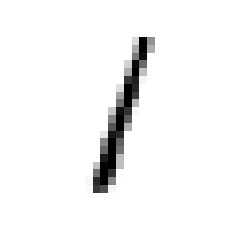

In [198]:
plt.imshow(X_test_digits_nrm_instance, cmap="binary")
plt.axis('off')
plt.show()

#### Simple Model Dropout -  `mc_model_simple_drp`

In [199]:
y_pred_mc_cnn_digit = np.round(np.mean([mc_model_simple_drp.predict(X_test_digits_nrm_cnn[2:3]) 
                                        for sample in tqdm(range(100))], axis=0), 2)
print(y_pred_mc_cnn_digit)


[[0.02 0.13 0.01 0.28 0.   0.48 0.01 0.05 0.   0.03]]


#### MC Dropout CNN

In [200]:
y_probas_mc_model_cnn_drp = np.stack([mc_model_cnn_drp(X_test_digits_nrm_cnn[2:3]) for sample in tqdm(range(100))])

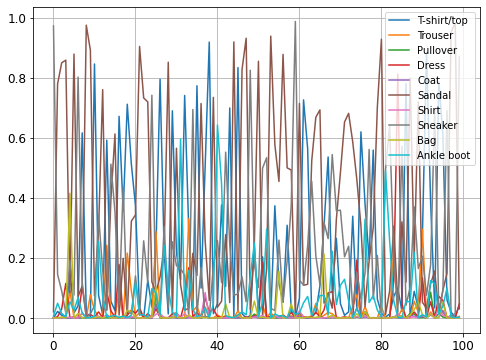

In [201]:
plot_predictions_distribution_for_single_instance(y_probas_mc_model_cnn_drp, class_names)

In [202]:
y_pred_mc_cnn_digit = np.round(np.mean([mc_model_cnn_drp.predict(X_test_digits_nrm_cnn[2:3]) 
                                        for sample in tqdm(range(100))], axis=0), 2)
print(y_pred_mc_cnn_digit)


[[0.15 0.02 0.   0.04 0.   0.45 0.   0.26 0.01 0.07]]


In [203]:
y_probas_mc_model_cnn_drp_2d = np.squeeze(y_probas_mc_model_cnn_drp)

In [204]:
y_probas_mc_model_cnn_drp_2d.shape

(100, 10)

In [205]:
probas_df = pd.DataFrame(data=y_probas_mc_model_cnn_drp_2d, columns=class_names)

In [206]:
probas_df.head()

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
0,0.000624,4.192163e-07,9.867059e-08,0.000006,1.074771e-07,0.020498,0.000002,0.971864,0.000006,0.006998
1,0.021861,4.669887e-04,6.592034e-07,0.004392,1.384356e-05,0.779247,0.000040,0.144798,0.000164,0.049015
2,0.008811,2.016510e-03,1.263339e-03,0.030118,5.704592e-04,0.849337,0.000511,0.090026,0.002172,0.015175
3,0.004307,2.956978e-04,7.339326e-04,0.114917,1.265688e-05,0.858150,0.001446,0.016340,0.000112,0.003686
4,0.159014,9.060095e-02,5.397949e-04,0.001300,2.327761e-04,0.084650,0.002763,0.191546,0.415246,0.054107


(array([51.,  8.,  8.,  5.,  5.,  3.,  6.,  5.,  5.,  4.]),
 array([1.9780821e-04, 9.2006192e-02, 1.8381457e-01, 2.7562296e-01,
        3.6743134e-01, 4.5923972e-01, 5.5104810e-01, 6.4285648e-01,
        7.3466486e-01, 8.2647324e-01, 9.1828161e-01], dtype=float32),
 <BarContainer object of 10 artists>)

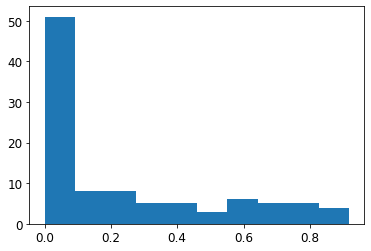

In [207]:
plt.hist(probas_df[class_names[0]])

In [208]:
from scipy.special import log_softmax

In [209]:
probas_df_log = probas_df.apply(log_softmax)

In [210]:
probas_df_log.head()

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
0,-4.882173,-4.635456,-4.608389,-4.642521,-4.607310,-5.013688,-4.609344,-3.901728,-4.620537,-4.677735
1,-4.860936,-4.634989,-4.608389,-4.638135,-4.607296,-4.254939,-4.609306,-4.728794,-4.620378,-4.635718
2,-4.873986,-4.633440,-4.607126,-4.612410,-4.606740,-4.184849,-4.608835,-4.783566,-4.618371,-4.669558
3,-4.878490,-4.635160,-4.607656,-4.527611,-4.607297,-4.176036,-4.607900,-4.857252,-4.620431,-4.681046
4,-4.723783,-4.544856,-4.607850,-4.641228,-4.607077,-4.949536,-4.606583,-4.682046,-4.205297,-4.630626


(array([51.,  8.,  8.,  5.,  5.,  3.,  6.,  5.,  5.,  4.]),
 array([-4.8825994, -4.790791 , -4.6989827, -4.6071744, -4.5153656,
        -4.4235573, -4.331749 , -4.2399406, -4.1481323, -4.056324 ,
        -3.9645154], dtype=float32),
 <BarContainer object of 10 artists>)

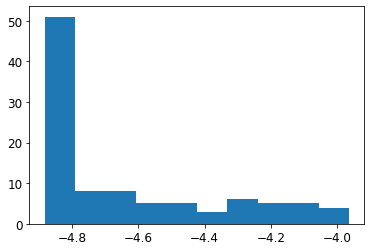

In [211]:
plt.hist(probas_df_log[class_names[0]])

In [212]:
probas_df_exp = probas_df_log.apply(np.exp)

In [213]:
probas_df_exp.head()

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
0,0.007581,0.009702,0.009968,0.009633,0.009979,0.006646,0.009958,0.020207,0.009848,0.009300
1,0.007743,0.009706,0.009968,0.009676,0.009979,0.014194,0.009959,0.008837,0.009849,0.009699
2,0.007643,0.009721,0.009980,0.009928,0.009984,0.015225,0.009963,0.008366,0.009869,0.009376
3,0.007608,0.009705,0.009975,0.010806,0.009979,0.015359,0.009973,0.007772,0.009849,0.009269
4,0.008882,0.010622,0.009973,0.009646,0.009981,0.007087,0.009986,0.009260,0.014916,0.009749


(array([58.,  7.,  7.,  5.,  4.,  5.,  4.,  5.,  3.,  2.]),
 array([0.00757729, 0.00871729, 0.00985728, 0.01099727, 0.01213727,
        0.01327726, 0.01441725, 0.01555725, 0.01669724, 0.01783724,
        0.01897723], dtype=float32),
 <BarContainer object of 10 artists>)

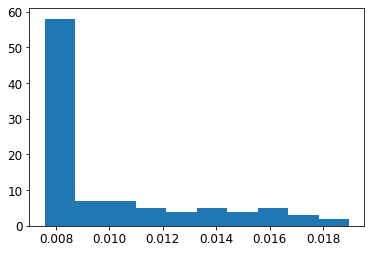

In [214]:
plt.hist(probas_df_exp[class_names[0]])

In [215]:
np.percentile(probas_df_exp["T-shirt/top"], 50)

0.008263609372079372

In [216]:
probas_df["T-shirt/top"].iloc[50]

0.017192863

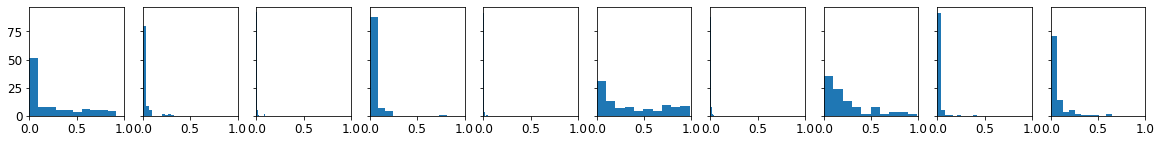

In [217]:
fig, axs = plt.subplots(1, len(class_names), sharey=True, figsize=(20,2))
for i in class_names:
    plt.subplot(1, len(class_names), class_names.index(i) + 1)  # 1 row, 2 cols, subplot X
    axs[class_names.index(i)].set_xlim([0, 1])
    plt.hist(probas_df[class_names[class_names.index(i)]])

#### Simple CNN

In [218]:
y_proba_softmax = model_cnn.predict(X_test_digits_nrm_cnn[2:3])
y_proba_softmax.round(2)

array([[0.05, 0.39, 0.02, 0.21, 0.09, 0.01, 0.13, 0.02, 0.04, 0.04]],
      dtype=float32)